# Example of hyperfine quadrupole spectrum of $\text{S}_2^{35}\text{Cl}^{37}\text{Cl}$ molecule

In this example, we simulate the rotational hyperfine spectrum of $\text{S}_2^{35}\text{Cl}^{37}\text{Cl}$, including the forbidden ortho-para transitions, observed by [Mizoguchi], and compare with results of theoretical simulations.

The hyperfine interaction is represented by the nuclear quadrupole coupling of the two chlorine nuclei.
Each chlorine nucleus has a nuclear spin of $I = \tfrac{3}{2}$ and a nuclear quadrupole moment of $Q(^{35}\text{Cl}) = -81.65$ mb and $Q(^{37}\text{Cl}) = -64.35$ mb  [Pyykkö].

The molecular geometry, dipole moment, and electric field gradient tensors (EFG) used in this simulation are defined in the module [s2cl2.py](s2cl2.py).

We employ effective-Hamiltonian constants for the pure rotational solutions, as given in Table 4 of [Mizoguchi].

References:
- [Mizoguchi] Mizoguchi, Otaa, Kanamori, Sumiyoshi, Endo, J. Mol. Spectrosc. 250 (2008) 86, DOI: http://dx.doi.org/10.1016/j.jms.2008.04.012
- [Pyykkö] Pyykkö, Year-2008 Nuclear Quadrupole Moments, Mol. Phys. 106 (2008) 1965, DOI: http://dx.doi.org/10.1080/00268970802018367

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import s2cl2
from scipy import constants
from scipy.sparse import csr_array

from richmol import CartTensor, HyperCartTensor, HyperStates, QuadMom, RotStates
from richmol.asymtop import inertia_tensor, com, write_xyz
from richmol.rotsym import R0, RalphaPi, RzBeta

plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern"]}
)

Rotate *ab initio* calculated geometry, dipole moment, and EFG tensors to the principal axes system (PAS).

In [2]:
atom_masses = s2cl2.atom_masses_35_37
atom_labels = s2cl2.atom_labels_35_37

# inertia tensor
imom = inertia_tensor(atom_masses, s2cl2.atom_xyz)

# PAS rotation matrix
d, v = np.linalg.eigh(imom)
pas = v.T

print("diagonal moments of inertia:", d)

# rotate Cartesian coordinates to PAS frame
atom_xyz = (s2cl2.atom_xyz - com(atom_masses, s2cl2.atom_xyz)) @ pas.T
write_xyz("s2cl2_35_37_pas_coords.xyz", atom_labels, atom_xyz)

# rotate Cartesian tensors to PAS frame
dip_mol = pas @ np.array(s2cl2.dip_mol)
efg_mol_cl1 = pas @ np.array(s2cl2.efg_mol_cl1) @ pas.T
efg_mol_cl2 = pas @ np.array(s2cl2.efg_mol_cl2) @ pas.T

dip_mol[0] = 0
dip_mol[2] = 0
print("Dipole moment, x, y, z:", s2cl2.dip_mol)
print("Dipole moment in PAS, a, b, c:", dip_mol)

diagonal moments of inertia: [ 92.34991054 369.42730418 417.41091319]
Dipole moment, x, y, z: [0.0, 0.0, 0.3647]
Dipole moment in PAS, a, b, c: [0.         0.36467618 0.        ]


In [3]:
# Rotational constants from [Mizoguchi]
inp = (
    "A/MHz",      5475.4344,
    "B/MHz",      1361.8640,
    "C/MHz",      1205.1953,
    "DeltaJ/kHz",    0.554,
    "DeltaJK/kHz",  -4.465,
    "DeltaK/kHz",   22.68,
    "d1/kHz",        0.054,
)

jmax = 10
states = RotStates.watson(
    jmax,
    inp,
    print_enr=True,
    rotations=[R0(), RalphaPi(0)],
    irreps={"A": [1, 1], "B": [1, -1]},
)


Compute rotational solutions using Watson's effective Hamiltonian approach
Input rotational constants (MHz):
          A  5475.434400000000 
          B  1361.864000000000 
          C  1205.195300000000 
     DeltaJ     0.000554000000 
    DeltaJK    -0.004465000000 
     DeltaK     0.022680000000 
         d1     0.000054000000 
Watson reduction form: S
Axes convention for near-prolate: I(r), xyz = bca
Remark: manually apply permutation (132) to other input Cartesian tensors (like dipole moment) in the PAS frame,
   e.g., using permutation matrix np.array([[0,1,0],[0,0,1],[1,0,0]])
solve for J = 0 and symmetry B ...
number of functions: 0
solve for J = 0 and symmetry A ...
number of functions: 1
Axes convention for near-prolate: I(r), xyz = bca
Remark: manually apply permutation (132) to other input Cartesian tensors (like dipole moment) in the PAS frame,
   e.g., using permutation matrix np.array([[0,1,0],[0,0,1],[1,0,0]])
solve for J = 1 and symmetry B ...
number of functions: 2
s

Compute hyperfine states using effective-Hamiltonian rotational states, ab initio calculated EFG tensors, and quadrupole moments from [Pyykkö].

In [4]:
# Compute rotational matrix elements of laboratory-frame tensors

# since the quantization z-axis corresponds to the a-axis (see output of RotStates run),
# swap axes such that xyz=bca, i.e., permute (132)
perm_mat = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
dip_lab = CartTensor(states, perm_mat @ dip_mol)
efg_lab_cl1 = CartTensor(states, perm_mat @ efg_mol_cl1 @ perm_mat.T)
efg_lab_cl2 = CartTensor(states, perm_mat @ efg_mol_cl2 @ perm_mat.T)

# Quadrupole moments of {35}^Cl and {37}^Cl (in mb) from [Pyykkö]

quad_cl35 = QuadMom(spin=3 / 2, Q=-81.65)
quad_cl37 = QuadMom(spin=3 / 2, Q=-64.35)

# Compute hyperfine states and matrix elements of laboratory-frame tensors

hyper_states = HyperStates(
    0,
    jmax - 3,
    states,
    spin_op=[quad_cl35, quad_cl37],
    efg_op=[efg_lab_cl1, efg_lab_cl2],
)

# convert matrix elements of lab-frame dipole moment to hyperfine basis
hyper_dip_lab = HyperCartTensor(hyper_states, dip_lab)


Compute hyperfine states
List of F quanta: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0)]
F   tot.sym.   J   (I_1, I_12, ... I_1N)     rovib.sym.   spin.sym.  rovib.dim 
----------------------------------------------------------------------------
0.0 A          0   (1.5, 0)                  A            A          1         
0.0 A          1   (1.5, 1)                  B            A          2         
0.0 A          1   (1.5, 1)                  A            A          1         
0.0 A          2   (1.5, 2)                  B            A          2         
0.0 A          2   (1.5, 2)                  A            A          3         
0.0 A          3   (1.5, 3)                  B            A          4         
0.0 A          3   (1.5, 3)                  A            A          3         
1.0 A          1   (1.5, 0)                  B            A          2         
1.0 A          1   (1.

In [5]:
v1 = perm_mat @ efg_mol_cl1 @ perm_mat.T
v2 = perm_mat @ efg_mol_cl2 @ perm_mat.T
print(np.round(v1, 3))
print(np.round(v2, 3))
for i in range(3):
    print(
        " & ".join("%10.3f" % v1[i, j] for j in range(3)) + " & "
        + " & ".join("%10.3f" % v2[i, j] for j in range(3)) + " \\\\"
    )

[[ 0.894  1.647  2.603]
 [ 1.647 -1.268  1.175]
 [ 2.603  1.175  0.374]]
[[ 0.824 -1.6   -2.624]
 [-1.6   -1.303  1.18 ]
 [-2.624  1.18   0.479]]
     0.894 &      1.647 &      2.603 &      0.824 &     -1.600 &     -2.624 \\
     1.647 &     -1.268 &      1.175 &     -1.600 &     -1.303 &      1.180 \\
     2.603 &      1.175 &      0.374 &     -2.624 &      1.180 &      0.479 \\


Print the hyperfine states and assignments, as well as the weights of ortho and para contributions.

In [6]:
# zero-point energy
zpe = np.min(
    [
        np.min(enr_sym)
        for enr_f in hyper_states.enr.values()
        for enr_sym in enr_f.values()
    ]
)

enr = []
for f in hyper_states.enr.keys():
    for sym in hyper_states.enr[f].keys():

        # extract (J, k, tau, I, F) quanta
        quanta = hyper_states.quanta_dict_k[f][sym]
        j_k_tau_i_f = [
            (*elem[6:9], elem[3], float(elem[0]))
            for elem in hyper_states.quanta_dict_k[f][sym]
        ]

        # p(I) = \sum_i |c_i|^2 for spin I=0,1,2,3
        op_quanta = hyper_states.quanta_dict_op[f][sym]

        # compute p(para) = \sum_i |c_i|^2 for spin in (0, 2)
        #     and p(ortho) = \sum_i |c_i|^2 for spin in (1, 3)
        para_coef = [sum(c for (q, c) in qua if int(q) in (0, 2)) for qua in op_quanta]
        ortho_coef = [sum(c for (q, c) in qua if int(q) in (1, 3)) for qua in op_quanta]

        # assemble (J, k, tau, I, F, energy-zpe, p(para), p(ortho))
        enr += [
            (*q, float(e - zpe), pc, oc)
            for q, e, pc, oc in zip(
                j_k_tau_i_f, hyper_states.enr[f][sym], para_coef, ortho_coef
            )
        ]


# sort wrt energy
enr = sorted(enr, key=lambda elem: elem[5])


print(
    f"{'J':>2} {'k':>2} {'tau':>1} {'I':>1} {'F':>2} {'Energy (MHz)':>16} {'p_para':>10} {'p_ortho':>10}"
)
for j, k, tau, spin, f, e, p_c, o_c in enr:
    print(
        f"{j:2d}",
        f"{k:2d}",
        f"{tau:2d}",
        f"{int(spin):2d}",
        f"{int(f):2d}",
        f"{e:16.4f}",
        f"{p_c:10.6f}",
        f"{o_c:10.6f}",
    )

 J  k tau I  F     Energy (MHz)     p_para    p_ortho
 0  0  0  2  2           0.0000   0.999996   0.000004
 0  0  0  1  1           0.0200   0.000002   0.999998
 0  0  0  3  3           0.0200   0.000002   0.999998
 0  0  0  0  0           0.0399   1.000000   0.000000
 1  0  1  1  0        2564.1876   0.000002   0.999998
 1  0  1  2  1        2564.7788   0.999990   0.000010
 1  0  1  3  3        2564.8988   0.000010   0.999990
 1  0  1  1  2        2565.8654   0.000056   0.999944
 1  0  1  2  2        2567.0185   0.999913   0.000087
 1  0  1  2  3        2567.0535   0.999989   0.000011
 1  0  1  3  4        2567.8052   0.000001   0.999999
 1  0  1  1  1        2568.4886   0.000272   0.999728
 1  0  1  0  1        2569.3398   0.999736   0.000264
 1  0  1  3  2        2569.6827   0.000030   0.999970
 1  1  1  1  0        6674.7188   0.000003   0.999997
 1  1  1  2  1        6675.6902   0.993782   0.006218
 1  1  1  3  3        6675.9410   0.013330   0.986670
 1  1  1  1  2        6677.5

### Compute spectrum

Define function `dipole_linestr` for computing transition linestrengths
$$
S(F',i\leftarrow F,j) = \sum_{m_F',m_F}\sum_{A=X,Y,Z}\left|\langle F',m_F',i|\mu_A|F,m_F,j\rangle\right|^2,
$$
where $i,j$ are indices of hyperfine states with total spin-rotational angular momentum $F'$ and $F$, respectively.

In [7]:
def dipole_linestr(
    dip: CartTensor,
) -> dict[tuple[float, float], dict[tuple[str, str], csr_array]]:
    assert (
        dip.rank == 1
    ), f"Unexpected rank of the input 'dip' tensor = {dip.rank} (must be equal to 1)"

    ls = {}
    for j_pair in list(set(dip.mmat.keys()) & set(dip.kmat.keys())):
        mmat = dip.mmat[j_pair]
        kmat = dip.kmat[j_pair]

        m_prefac = np.sum(
            [np.sum(np.abs(mmat_cart[1]) ** 2) for mmat_cart in mmat.values()]
        )  # must be equal to (2*j1+1)*(2*j2+1), where j1,j2=j_pair

        ls_sym = {}
        for sym_pair, kmat_s in kmat.items():
            ls_sym[sym_pair] = m_prefac * np.abs(kmat_s[1]) ** 2

        if ls_sym:
            ls[j_pair] = ls_sym

    return ls

Compute linestrenghts for all states in `hyper_states`.

In [8]:
ls = dipole_linestr(hyper_dip_lab)

Estimate partition function.

In [9]:
temp = 3.0  # Kelvin
boltz_beta = constants.h / (constants.k * temp) * 1e6

enr, m_degen = np.array(
    [
        (e, 2 * f + 1)
        for f in hyper_states.f_list
        for sym in hyper_states.f_sym_list[f]
        for e in hyper_states.enr[f][sym]
    ]
).T
zpe = np.min(enr)

part_func = np.sum(m_degen * np.exp(-(enr - zpe) * boltz_beta))
print(f"partition function for (T = {temp} K):", part_func)

partition function for (T = 3.0 K): 2999.369064838622


Define function `stick_spectrum` for computing absorption intensities for selected frequency range.

In [10]:
def stick_spectrum(nu1, nu2):
    fac_cm_molecule = 8.0e-41 * np.pi**3 / (3.0 * constants.h * constants.c**2)

    freq = []
    abscoef = []
    spin_diff = []

    for (f1, f2), ls_j in ls.items():
        for (sym1, sym2), ls_sym in ls_j.items():

            enr1 = hyper_states.enr[f1][sym1]
            enr2 = hyper_states.enr[f2][sym2]
            spin1 = np.array(
                [int(qua[0][0]) for qua in hyper_states.quanta_dict_op[f1][sym1]]
            )
            spin2 = np.array(
                [int(qua[0][0]) for qua in hyper_states.quanta_dict_op[f2][sym2]]
            )

            # absorption coefficients

            spin12 = np.abs(spin1[:, None] - spin2[None, :])
            nu = np.abs(enr1[:, None] - enr2[None, :])
            cond = enr1[:, None] < enr2[None, :]
            elow = np.where(cond, enr1[:, None], enr2[None, :])
            boltz_fac = np.exp(-(elow - zpe) * boltz_beta) / part_func
            intens = (
                ls_sym
                * boltz_fac
                * nu
                * (1 - np.exp(-abs(nu) * boltz_beta))
                * fac_cm_molecule
            )

            if f1 == f2:
                ind = np.triu_indices(n=len(enr1), m=len(enr2), k=1)
            else:
                ind = np.triu_indices(n=len(enr1), m=len(enr2), k=0)

            nu = nu[ind]
            intens = intens.toarray()[ind]
            spin12 = spin12[ind]

            ind = np.where((nu >= nu1) & (nu <= nu2))
            abscoef.append(intens[ind])
            freq.append(nu[ind])
            spin_diff.append(spin12[ind])

    freq = np.concatenate(freq)
    abscoef = np.concatenate(abscoef)
    spin_diff = np.concatenate(spin_diff)
    return freq, abscoef, spin_diff

Plot stick spectrum for different frequency ranges, compare with simulations from [Mizoguchi], Fig. 3.b.

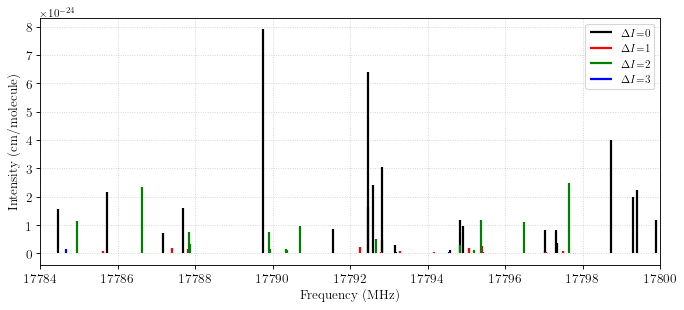

In [11]:
# frequency range (MHz)
nu1 = 17784
nu2 = 17800
freq, abscoef, spin_diff = stick_spectrum(nu1, nu2)

fig = plt.figure(figsize=(10, 4), dpi=80)

color = ("black", "red", "green", "blue")

for diff in range(4):
    ind = np.where(spin_diff == diff)[0]
    if len(ind) == 0:
        continue

    plt.vlines(
        freq[ind],
        ymin=0,
        ymax=abscoef[ind],
        color=color[diff],
        linewidth=2,
        label=f"$\\Delta I$={diff}",
    )

plt.xlim([nu1, nu2])
plt.grid(True, linestyle=":", alpha=0.6)
plt.xlabel("Frequency (MHz)", fontsize=12)
plt.ylabel("Intensity (cm/molecule)", fontsize=12)
plt.tick_params(axis="both", labelsize=12)
plt.legend()
plt.show()

For comparision, here is an extract of Fig. 3.b from [Mizoguchi]

<img src="../etc/data/s2cl2/Mizoguchi_JMolSpec250_2008_FIg3.b.png" alt="Extract from Fig. 3 in Mizoguchi, et al. J. Mol. Spectrosc. 250 (2008) 86" width="800"/>

Plot full spectrum.

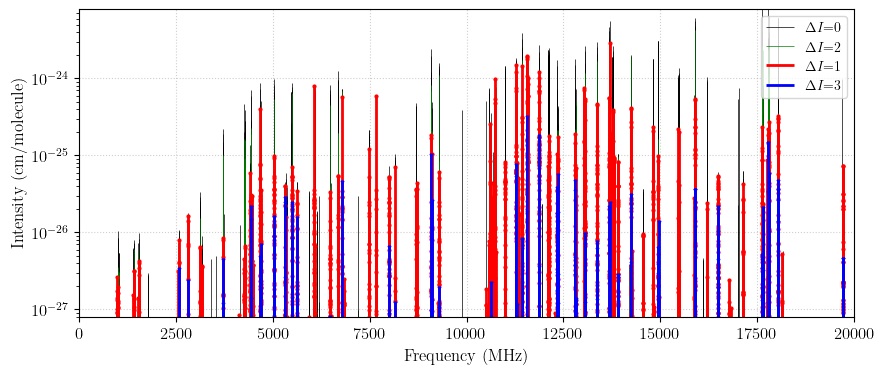

In [12]:
# frequency range (MHz)
nu1 = 0
nu2 = 20000
freq, abscoef, spin_diff = stick_spectrum(nu1, nu2)

fig = plt.figure(figsize=(10, 4), dpi=100)

color = ("black", "red", "green", "blue")
linewidth = (0.5, 2, 0.5, 2)
marker = ("", "o", "", "v")

for diff in (0, 2, 1, 3):
    ind = np.where(spin_diff == diff)[0]
    if len(ind) == 0:
        continue

    plt.vlines(
        freq[ind],
        ymin=0,
        ymax=abscoef[ind],
        color=color[diff],
        linewidth=linewidth[diff],
        label=f"$\\Delta I$={diff}",
    )

    if marker[diff]:
        plt.plot(
            freq[ind],
            abscoef[ind],
            linestyle="None",
            color=color[diff],
            marker=marker[diff],
            markersize=2,
        )

plt.yscale("log")
plt.xlim([nu1, nu2])
plt.ylim([np.max(abscoef) * 1e-4, np.max(abscoef)])
plt.grid(True, linestyle=":", alpha=0.6)
plt.xlabel("Frequency (MHz)", fontsize=12)
plt.ylabel("Intensity (cm/molecule)", fontsize=12)
plt.tick_params(axis="both", labelsize=12)
plt.legend()
plt.show()